In [1]:
import networkx as nx
from typing import Union, Optional

In [2]:
def generate_latin_square_graph(n:int) -> nx.Graph:
    """Generates an nxn graph that will contain the connections for a Latin Square

    Args:
        n (int): size of latin square

    Returns:
        nx.Graph: Graph containing nodes and connections necessary
    """
    g = nx.Graph()
    #Add all nxn nodes
    for row in range(n):
        for col in range(n):
            g.add_node((row, col))
    
    #Generate all connections between nodes
    for row in range(n):
        for col in range(n):
            #Previous rows and columns have a connection already. This reduces duplicate work.
            row_neighbors = [row_ for row_ in range(row, n) if row_ != row]
            col_neighbors = [col_ for col_ in range(col, n) if col_ != col]
            for row_neighbor in row_neighbors:
                g.add_edge((row, col), (row_neighbor, col))
            for col_neighbor in col_neighbors:
                g.add_edge((row, col), (row, col_neighbor))
    return g

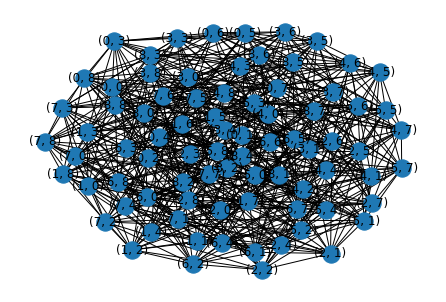

In [3]:
k = 9
g = generate_latin_square_graph(9)
nx.draw(g, with_labels=True)

The following algorithm works as follows:

It assumes that the $k \times k$ graph *can* be colored with $k$ colors, which is a valid assumption for the Latin Squares.

It will then iterate across every column first, then across every row.
```python:
for row in graph:
    for column in row:
        "do things"
```

This is achieved by the `int_index_to_tuple` function defined below. You can alternate the order very easily by reversing the output tuple if you desire, it will have nearly no effect. When the point is at an index, it will then iterate through all $k$ colors to identify a safe color to assign for that node. It does this by looking at the neighbors. If any of the neighbors has the color in question already assigned, it will move on to the next one. If the color is safe, it will move on to the next index by calling the same function, albeit with the next index. Here is where the recursion begins. We will call the index we are on $n$, and the next index as $n+1$. If state $n+1$ returns `True`, it means state $n+2$ returned `True`, all the way down. If state $n+1$ does not return `True`, it means at some point the coloring failed. As such, the current coloring attempted at state $n$ is discarded, and the next color is attempted again. Should every color fail, the algorithm will revert to state $n-1$, and so on and so forth. As such, it will attempt to backtrack and try again with a new color until it gets it right.

In [4]:
def decision_coloring(graph:nx.Graph, num_colors:Union[int, list[int]], pre_solved:dict[tuple[int,int],int] = {}) -> dict[tuple[int,int], int]:
    """Color the input graph according to the number of colors given

    Args:
        graph (nx.Graph): Graph to color
        num_colors (int): Number of colors to use

    Returns:
        dict[tuple[int,int], int]: Dictionary of node colors
    """
    #Initialize the color map. If a pre-solved dictionary is given, accept them as true.
    color_map   = {**pre_solved}
    graph_order = int(len(graph.nodes) ** 0.5)

    #If num_colors is a list, use it as the color seed.
    if isinstance(num_colors, int):
        color_seed = list(range(num_colors))
    else:
        if not all(isinstance(n, int) for n in num_colors):
            raise ValueError("num_colors must be a list of integers")
        color_seed = [*num_colors]
    
    def int_index_to_tuple(idx:int) -> tuple[int,int]:
        return (idx // graph_order, idx % graph_order)
    
    def safe_to_color(tup:tuple[int,int], color:int) -> bool:
        neighbors       = graph.neighbors(tup)
        neighbor_colors = [color_map.get(neighbors, None) for neighbors in neighbors]
        return color not in neighbor_colors
    
    def backtrack_solver(int_index:int = 0) -> bool:
        """Recursive backtracking solver for coloring the graph

        Args:
            int_index (int): Index of the node to color

        Returns:
            bool: True if the graph has been colored, None if the graph failed to color
        """
        #Convert the integer index to the (row, col) form
        idx = int_index_to_tuple(int_index)

        #If the integer index has reached the end of the graph, return True.
        #This will only happen once the graph has been colored.
        if int_index == len(graph.nodes):
            return True
        
        #Iterate through all possible colors, ignoring neighbors.
        for color in color_seed:
            #If the color is safe to use, assign it to the node and recurse with the next node.
            if safe_to_color(idx, color):
                color_map[idx] = color
                #Because the recursion will only return True if every subsequent node has been colored correctly,
                #the graph is colored if the recursion returns True.
                if backtrack_solver(int_index + 1):
                    return True
                #If the recursion fails, remove the previous assignment and try again
                color_map.pop(idx)
    
    if backtrack_solver() is None:
        raise ValueError("Could not solve graph")
    
    return color_map

In [5]:
def generate_latin_square(n:int, color_seed:Optional[list[int]] = None) -> list[list[int]]:
    """Generates a latin square of size n

    Args:
        n (int): size of latin square

    Returns:
        list[list[int]]: List of lists representing latin square
    """
    g           = generate_latin_square_graph(n)
    if color_seed is None:
        color_seed = list(range(n))
    color_map   = decision_coloring(g, color_seed)
    return [[color_map[(row, col)] for col in range(n)] for row in range(n)]

In [6]:
generate_latin_square(11)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [1, 0, 3, 2, 5, 4, 7, 6, 9, 10, 8],
 [2, 3, 0, 1, 6, 7, 4, 5, 10, 8, 9],
 [3, 2, 1, 0, 7, 8, 9, 10, 4, 5, 6],
 [4, 5, 6, 7, 0, 9, 10, 8, 1, 2, 3],
 [5, 4, 7, 6, 1, 10, 8, 9, 0, 3, 2],
 [6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5],
 [7, 6, 9, 10, 8, 1, 2, 3, 5, 0, 4],
 [8, 9, 10, 4, 2, 3, 5, 0, 6, 1, 7],
 [9, 10, 5, 8, 3, 2, 0, 4, 7, 6, 1],
 [10, 8, 4, 5, 9, 6, 3, 1, 2, 7, 0]]

In [7]:
def validate_latin_square(square:list[list[int]]) -> bool:
    """Validates that the input is a valid latin square

    Args:
        square (list[list[int]]): List of lists representing latin square

    Returns:
        bool: True if valid, False otherwise
    """
    n = len(square)
    for row in range(n):
        for col in range(n):
            cell = square[row][col]
            for i in range(n):
                if (square[row][i] == cell) and (i != col):
                    print(f"Row {row} has duplicate {cell} at {col} and {i}")
                    return False
                if (square[i][col] == cell) and (i != row):
                    print(f"Column {col} has duplicate {cell} at {row} and {i}")
                    return False
    return True

validate_latin_square(generate_latin_square(11))

True

In [9]:
import numpy as np
color_seed = list(range(11))
np.random.shuffle(color_seed)
latin_square = generate_latin_square(11, color_seed)
valid = validate_latin_square(latin_square)
print(f"Valid: {valid}")
latin_square

Valid: True


[[6, 5, 1, 7, 2, 9, 4, 8, 3, 10, 0],
 [5, 6, 7, 1, 9, 2, 8, 4, 10, 0, 3],
 [1, 7, 6, 5, 4, 8, 2, 9, 0, 3, 10],
 [7, 1, 5, 6, 8, 3, 10, 0, 2, 9, 4],
 [2, 9, 4, 8, 6, 10, 0, 3, 5, 1, 7],
 [9, 2, 8, 4, 5, 0, 3, 10, 6, 7, 1],
 [4, 8, 3, 10, 0, 6, 5, 1, 7, 2, 9],
 [8, 4, 10, 0, 3, 5, 1, 7, 9, 6, 2],
 [3, 10, 0, 2, 1, 7, 9, 6, 4, 5, 8],
 [10, 0, 9, 3, 7, 1, 6, 2, 8, 4, 5],
 [0, 3, 2, 9, 10, 4, 7, 5, 1, 8, 6]]